### HW3 | Use LSTM & CNN model to classify customized candlestick pattern (at least 3 classes)
- 所有檔案: process_data.py、candlestick_train_lstm.py、candlestick_train_cnn.py
<br />
<br />
- 內容說明: 運用作業一標示完兩個選定訊號(Hammer, HangingMan)的資料結果，透過 GASF 方法將原先資料轉換過後，代入作業二所訓練好的 LSTM 與CNN 模型，檢測在不同資料特徵的輸入下，兩模型對於不同candlestick pattern與signal的分類結果。
<br />
<br />
- 結果摘要: iterations = 10, testing accuracy results with 2 models & 2 features<br />
 (1) CURL 較 OHLC 對於捕捉資料特徵有更佳的結果<br />
 (2) CNN 模型對比於 LSTM 模型又有更高的模型精確度<br />
 (3) 資料特徵採用 CURL 並搭配 CNN 模型，檢測結果為四種情境下最佳模型精確度，分類準確度高達 92.12%<br />
 
| Data Features | LSTM model | CNN model |
|:-------------:|:----------:|:---------:|
|      OHLC     |   0.8281   |   0.8725  |
|      CURL     |   0.9156   |   0.9212  |



### 0. 處理資料
- process_data.py
1. 將HW1標示完兩個指定訊號(Hammer, HangingMan)的資料結果，透過Gramian Angular Summation Field(GASF)方法由時間序列資料轉換為二維圖像
2. x_train: 參考Reference 2的論文內容，分別擷取candlestick的兩組特徵(OHLC, CURL)
   * OHLC: open, high, low, close price
   * CURL: close, up_shadow_width, real_body, low_shadow_width
3. y_train: 三種不同判別訊號，分別為None、Hammer、HangingMan
4. 訓練集(train)、驗證集(val)與測試集(test)資料數量設定：

| Class |   pattern  | train | validate | test |
|:-----:|:----------:|:-----:|:--------:|:----:|
|   0   |    None    |  4000 |    800   |  800 |
|   1   |   Hammer   |  2000 |    400   |  400 |
|   2   | HangingMan |  2000 |    400   |  400 |
|       |    Total   |  8000 |   1600   | 1600 |

In [229]:
import pandas as pd
import numpy as np

# GASF
def ts2gasf(ts, max_v, min_v):
    '''
    Args:
        ts (numpy): (N, )
        max_v (int): max value for normalization
        min_v (int): min value for normalization
    Returns:
        gaf_m (numpy): (N, N)
    '''
    # Normalization : 0 ~ 1
    if max_v == min_v:
        gaf_m = np.zeros((len(ts), len(ts)))
    else:
        ts_nor = np.array((ts-min_v) / (max_v-min_v))
        # Arccos
        ts_nor_arc = np.arccos(ts_nor)
        # GAF
        gaf_m = np.zeros((len(ts_nor), len(ts_nor)))
        for r in range(len(ts_nor)):
            for c in range(len(ts_nor)):
                gaf_m[r, c] = np.cos(ts_nor_arc[r] + ts_nor_arc[c])
    return gaf_m


def get_gasf(arr):
    '''Convert time-series to gasf    
    Args:
        arr (numpy): (N, ts_n, 4)
    Returns:
        gasf (numpy): (N, ts_n, ts_n, 4)
    Todos:
        add normalization together version
    '''
    arr = arr.copy()
    gasf = np.zeros((arr.shape[0], arr.shape[1], arr.shape[1], arr.shape[2]))
    for i in range(arr.shape[0]):
        for c in range(arr.shape[2]):
            each_channel = arr[i, :, c]
            c_max = np.amax(each_channel)
            c_min = np.amin(each_channel)
            each_gasf = ts2gasf(each_channel, max_v=c_max, min_v=c_min)
            gasf[i, :, :, c] = each_gasf
    return gasf


def get_arr_ohlc(data, signal, d=None):
    if signal != 'n' and signal != 'None':
        df_es = data.loc[data[signal]==1]
    elif signal == 'None':
        df_es = data.loc[data[signal]==1][:10000]
    else:
        df_es = d
    arr = np.zeros((df_es.shape[0], 10, 4))
    for index, N in zip(df_es.index, range(df_es.shape[0])):
        df = data.loc[data.index <= index][-10::]
        arr[N, :, 0] = df['open']
        arr[N, :, 1] = df['high']
        arr[N, :, 2] = df['low']
        arr[N, :, 3] = df['close']
    return arr

def get_arr_curl(data, signal, d=None):
    if signal != 'n' and signal != 'None':
        df_es = data.loc[data[signal]==1]
    elif signal == 'None':
        df_es = data.loc[data[signal]==1][:10000]
    else:
        df_es = d
    arr = np.zeros((df_es.shape[0], 10, 4))
    for index, N in zip(df_es.index, range(df_es.shape[0])):
        df = data.loc[data.index <= index][-10::]
        arr[N, :, 0] = df['close']
        arr[N, :, 1] = df['ushadow_width']
        arr[N, :, 2] = df['realbody']
        arr[N, :, 3] = df['lshadow_width']
    return arr
    
    
def process(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d %H:%M:%S.%f")
    data.set_index('date', inplace=True)
    return data


def detect(data, datatype, signal, d=None):
    if datatype == 'curl':
        arr = get_arr_curl(data, signal, d)
    else:
        arr = get_arr_ohlc(data, signal, d)
    gasf = get_gasf(arr)
    return gasf


def partial_data(arr0, arr1, arr2):
    N_train1, N_train2 = 4000, 2000
    N_val1, N_val2 = 800, 400
    N_test1, N_test2 = 800, 400

    train_arr = np.concatenate((arr0[:N_train1], arr1[:N_train2], arr2[:N_train2]))
    val_arr = np.concatenate((arr0[N_train1: N_train1+N_val1], 
                              arr1[N_train2: N_train2+N_val2], 
                              arr2[N_train2: N_train2+N_val2]))

    test_arr = np.concatenate((arr0[N_train1+N_val1: N_train1+N_val1+N_test1], 
                               arr1[N_train2+N_val2: N_train2+N_val2+N_test2], 
                               arr2[N_train2+N_val2: N_train2+N_val2+N_test2]))
    
    return train_arr, val_arr, test_arr

In [230]:
def data_csv2dict(file, datatype):
    data = process(file)
    
    signal0, signal1, signal2 = 'None', 'Hammer', 'HangingMan'
    gasf_sig0 = detect(data, datatype, signal0, d=None)
    gasf_sig1 = detect(data, datatype, signal1, d=None)
    gasf_sig2 = detect(data, datatype, signal2, d=None)

    N_none = gasf_sig0.shape[0]
    N_hammer = gasf_sig1.shape[0]
    N_hangingman = gasf_sig2.shape[0]

    # Create the label array
    label0 = np.array([[0]]*N_none, dtype = float)
    label1 = np.array([[1]]*N_hammer, dtype = float)
    label2 = np.array([[2]]*N_hangingman, dtype = float)

    # Create the label_arr array
    label_arr0 = np.array([[1, 0, 0]]*N_none, dtype = float)
    label_arr1 = np.array([[0, 1, 0]]*N_hammer, dtype = float)
    label_arr2 = np.array([[0, 0, 1]]*N_hangingman, dtype = float)
    
    train_label, val_label, test_label = partial_data(label0, label1, label2)
    train_label_arr, val_label_arr, test_label_arr = partial_data(label_arr0, label_arr1, label_arr2)
    train_gasf, val_gasf, test_gasf = partial_data(gasf_sig0, gasf_sig1, gasf_sig2)

    ALL_arr_name = ['train_gasf', 'val_gasf', 'test_gasf',
                    'train_label', 'val_label', 'test_label',
                    'train_label_arr', 'val_label_arr', 'test_label_arr']

    ALL_arr = [train_gasf, val_gasf, test_gasf,
               train_label, val_label, test_label,
               train_label_arr, val_label_arr, test_label_arr]

    data_dict = {}
    for i in range(len(ALL_arr)):
        data_dict[ALL_arr_name[i]] = ALL_arr[i]
        
    return data_dict

In [232]:
file = 'C:/Users/user.LAPTOP-EQJHNTF3/Desktop/1091/Financial_Vision/HW3/data/eurusd_2010_2012_2rulebase.csv'
data_dict1 = data_csv2dict(file, datatype = 'ohlc')
data_dict2 = data_csv2dict(file, datatype = 'curl')

### Model Training

### 1. LSTM
- candlestick_train_lstm.py

In [310]:
from sklearn.metrics import confusion_matrix
import pickle
import keras
from keras.layers import LSTM
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def lstm_preprocess(x_train, x_test, y_train, y_test, n_step, n_input, n_classes):
    x_train = x_train.reshape(-1, n_step, n_input)
    x_test = x_test.reshape(-1, n_step, n_input)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    y_train = keras.utils.to_categorical(y_train, n_classes)
    y_test = keras.utils.to_categorical(y_test, n_classes)
    return (x_train, x_test, y_train, y_test)

def lstm_model(x_train, n_input, n_step, n_hidden, n_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

def train_lstm(model, x_train, y_train, x_test, y_test, 
        learning_rate, training_iters, batch_size):
    adam = Adam(lr=learning_rate)
    model.summary()
    model.compile(optimizer=adam,
        loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train,
        batch_size=batch_size, epochs=training_iters,
        verbose=1, validation_data=(x_test, y_test))

def mnist_lstm_main(data):
    # training parameters
    learning_rate = 0.001
    training_iters = 10
    batch_size = 128

    # model parameters
    n_input = 40
    n_step = 10
    n_hidden = 256
    n_classes = 3

    x_train, y_train, x_test, y_test = data['train_gasf'], data['train_label'][:, 0], data['test_gasf'], data['test_label'][:, 0]
    x_train, x_test, y_train, y_test = lstm_preprocess(x_train, x_test, y_train, y_test, n_step, n_input, n_classes)

    model = lstm_model(x_train, n_input, n_step, n_hidden, n_classes)
    train_lstm(model, x_train, y_train, x_test, y_test, learning_rate, training_iters, batch_size)
    scores = model.evaluate(x_test, y_test, verbose=0)
    print('LSTM test accuracy:', scores[1])

    # Plot Confusion Matrix
    # get train & test predictions
    train_pred = model.predict_classes(x_train)
    test_pred = model.predict_classes(x_test)

    # confusion matrix
    train_result_cm = confusion_matrix(data['train_label'][:, 0], train_pred, labels=range(3))
    test_result_cm = confusion_matrix(data['test_label'][:, 0], test_pred, labels=range(3))

    plot_confusion_matrix(train_result_cm, range(0, 3))
    plot_confusion_matrix(test_result_cm, range(0, 3))



#### 1-1 Result of LSTM model (OHLC data)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 10, 128)           86528     
_________________________________________________________________
dropout_111 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_112 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)                4128      
_________________________________________________________________
dropout_113 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 3)               

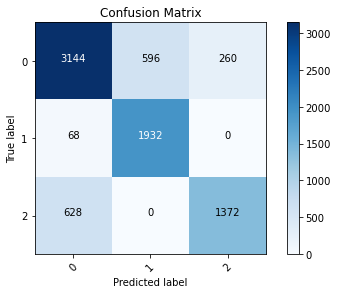

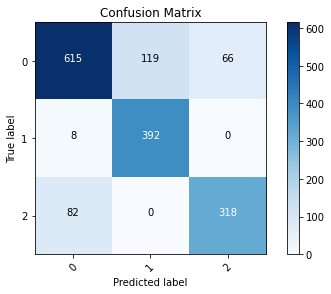

In [311]:
mnist_lstm_main(data_dict1)  # data input: OHLC

#### 1-2 Result of LSTM model (CURL data)

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 10, 128)           86528     
_________________________________________________________________
dropout_114 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_115 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 32)                4128      
_________________________________________________________________
dropout_116 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 3)               

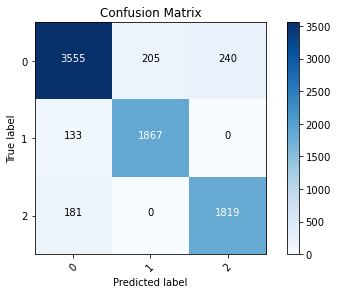

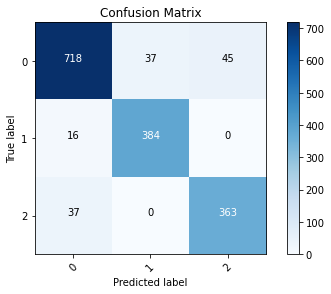

In [312]:
mnist_lstm_main(data_dict2)  # data input: CURL

### 2. CNN
- candlestick_train_cnn.py
- 原先CNN model在移除pooling layer後，模型準確度有明顯上升

In [323]:
from sklearn.metrics import confusion_matrix
import numpy as np

from keras import backend as K
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Activation, MaxPool2D, MaxPooling2D

def get_cnn_model(params):
    model = Sequential()

    model.add(Conv2D(32, (5,5), activation="relu", padding="same", data_format="channels_last", input_shape=(10, 10, 4)))
    model.add(Conv2D(32, (5,5), activation="relu", padding="same", data_format="channels_last", input_shape=(10, 10, 4)))
    #model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))
    model.add(Dropout(0.25))

    model.add(Conv2D(48, (3,3), activation="relu", padding="same", data_format="channels_last"))
    model.add(Conv2D(48, (3,3), activation="relu", padding="same", data_format="channels_last"))
    #model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax"))
    return model

def train_model(params, data):
    model = get_cnn_model(params)
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    hist = model.fit(x=data['train_gasf'], y=data['train_label_arr'],
                     batch_size=params['batch_size'], epochs=params['epochs'], verbose=2)
    return (model, hist)


In [324]:
def mnist_cnn_main(data):
    # data
    PARAMS = {}
    PARAMS['classes'] = 3
    PARAMS['lr'] = 0.01
    PARAMS['epochs'] = 10
    PARAMS['batch_size'] = 64
    PARAMS['optimizer'] = optimizers.SGD(lr=PARAMS['lr'])

    x_train, y_train, x_test, y_test = data['train_gasf'], data['train_label'][:, 0], data['test_gasf'], data['test_label'][:, 0]
    # train cnn model
    model, hist = train_model(PARAMS, data)
    # train & test result
    scores = model.evaluate(data['test_gasf'], data['test_label_arr'], verbose=0)
    print('CNN test accuracy:', scores[1])

    # Plot Confusion Matrix
    # get train & test predictions
    train_pred = model.predict_classes(x_train)
    test_pred = model.predict_classes(x_test)

    # confusion matrix
    train_result_cm = confusion_matrix(data['train_label'][:, 0], train_pred, labels=range(3))
    test_result_cm = confusion_matrix(data['test_label'][:, 0], test_pred, labels=range(3))

    plot_confusion_matrix(train_result_cm, range(0, 3))
    plot_confusion_matrix(test_result_cm, range(0, 3))

#### 2-1 Result of CNN model (with OHLC data)

Epoch 1/10
 - 5s - loss: 0.8881 - accuracy: 0.5471
Epoch 2/10
 - 5s - loss: 0.6877 - accuracy: 0.6526
Epoch 3/10
 - 5s - loss: 0.5854 - accuracy: 0.7262
Epoch 4/10
 - 6s - loss: 0.5177 - accuracy: 0.7684
Epoch 5/10
 - 5s - loss: 0.4566 - accuracy: 0.7994
Epoch 6/10
 - 5s - loss: 0.4175 - accuracy: 0.8241
Epoch 7/10
 - 5s - loss: 0.3872 - accuracy: 0.8350
Epoch 8/10
 - 5s - loss: 0.3638 - accuracy: 0.8471
Epoch 9/10
 - 6s - loss: 0.3492 - accuracy: 0.8555
Epoch 10/10
 - 5s - loss: 0.3415 - accuracy: 0.8555
CNN test accuracy: 0.8725000023841858


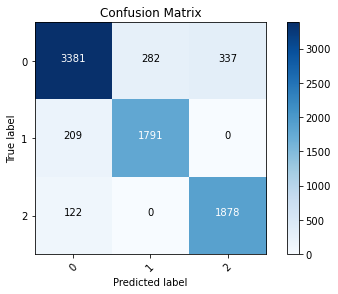

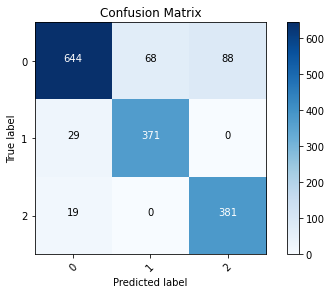

In [325]:
mnist_cnn_main(data_dict1)  # OHLC

#### 2-2 Result of CNN model (with CURL data)

Epoch 1/10
 - 6s - loss: 0.9374 - accuracy: 0.5451
Epoch 2/10
 - 5s - loss: 0.5628 - accuracy: 0.7561
Epoch 3/10
 - 6s - loss: 0.3944 - accuracy: 0.8341
Epoch 4/10
 - 5s - loss: 0.3406 - accuracy: 0.8572
Epoch 5/10
 - 6s - loss: 0.3089 - accuracy: 0.8710
Epoch 6/10
 - 5s - loss: 0.2856 - accuracy: 0.8830
Epoch 7/10
 - 6s - loss: 0.2732 - accuracy: 0.8869
Epoch 8/10
 - 5s - loss: 0.2619 - accuracy: 0.8945
Epoch 9/10
 - 5s - loss: 0.2524 - accuracy: 0.8957
Epoch 10/10
 - 5s - loss: 0.2417 - accuracy: 0.9024
CNN test accuracy: 0.9212499856948853


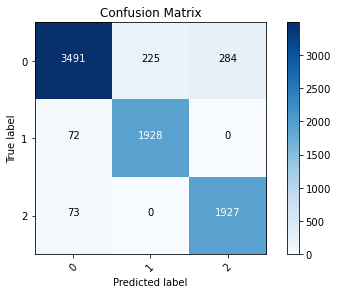

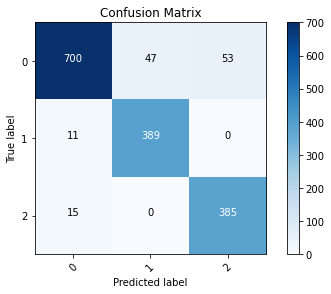

In [327]:
mnist_cnn_main(data_dict2)  # CURL

### Reference

- GASF代碼參考: [github/pecu/Series2GAF](https://github.com/pecu/Series2GAF)
- [Encoding candlesticks as images for pattern classification using convolutional neural networks_Jun-Hao Chen & Yun-Cheng Tsai](https://jfin-swufe.springeropen.com/articles/10.1186/s40854-020-00187-0)